<a href="https://colab.research.google.com/github/ziatdinovmax/AICrystallographer/blob/master/Tutorials/AtomicImageCleaningSimplified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "Atom" Image Cleaning in PyTorch (Simplified)

Author: Maxim Ziatdinov

E-mail: ziatdinovmax@gmail.com

---

In this notebook tutorial, we are going to implement a simple neural network called [denosing autoencoder](https://en.wikipedia.org/wiki/Autoencoder#Denoising_autoencoder) for locating atoms in noisy images of artificial periodic atomic lattice. The atoms will be modeled as 2D Gaussian blobs. We will not be considering any lattice defects or any deviations from the ideal periodicity, which are common in real materials.<br><br>
This notebook contains several simple fill-in-the-blank type of "problems". The "solutions" can be found [here](https://colab.research.google.com/drive/1Ll81JQ5tP9V3OoNJkk8Jy-S-KLl1RICF). 

---

## Construct artificial "atomic lattice"

First we are going to (down)load an image-label pair, that is, a single "atom" blob with a corresponding mask, and use it to create a periodic lattice by taking advantage of a simple [tile operation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.tile.html) from a numpy module.

Import NumPy and Matplotlib modules:

In [0]:
# for data manipulation
import numpy as np
# for plotting
import matplotlib.pyplot as plt

(Down)load 2d numpy arrays/images of single "atom" and "atomic contour" mask:

In [0]:
!gdown https://drive.google.com/uc?id=1nJZ9OmrbHVLZIRlCylb5cYrOxnqBLCYq
!gdown https://drive.google.com/uc?id=1E5RXv5YTXteD7IQZbT1YOcTWfswZ3j_k 
atom = np.load('atom2.npy')
label = np.load('gt2.npy')

Downloading...
From: https://drive.google.com/uc?id=1nJZ9OmrbHVLZIRlCylb5cYrOxnqBLCYq
To: /content/atom2.npy
100% 13.6k/13.6k [00:00<00:00, 11.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1E5RXv5YTXteD7IQZbT1YOcTWfswZ3j_k
To: /content/gt2.npy
100% 13.6k/13.6k [00:00<00:00, 11.5MB/s]


Plot the data we just loaded:

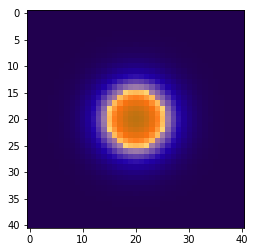

In [0]:
plt.imshow(atom, cmap='seismic')
plt.imshow(label, alpha=0.5)

Tile both "atom" and "label" arrays to create an "atomic lattice":

**You will need to write an expression for tiling labels on your own (line 4)**

In [0]:
tile_n = 5 # controls number of repetition (use as 2*tile_n to allow 2x-max-pooling operations during neural network training)

atomic_lattice = np.tile(atom, (2*tile_n, 2*tile_n))
atomic_lattice_labels = # your code here

Plot tiled data (labels overlaid with atomic lattice):

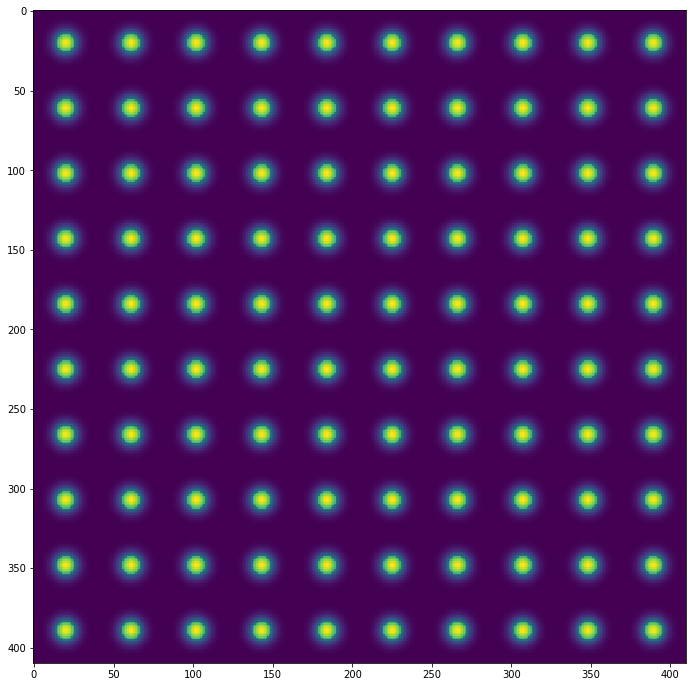

In [0]:
plt.figure(figsize=(12, 12))
plt.imshow(atomic_lattice)
plt.imshow(atomic_lattice_labels, alpha=0.2)

Add noise to "atomic lattice" *only* (we are not going to apply noise to labels):

**You will need to complete the code for generating noisy "atomic lattice" on line 2.**

In [0]:
noise_level = 3
atomic_lattice_noisy = atomic_lattice + noise_level * # your code for random noise generaton here (finish this expression)

Plot noisy "atomic lattice" with the labels overlaid:

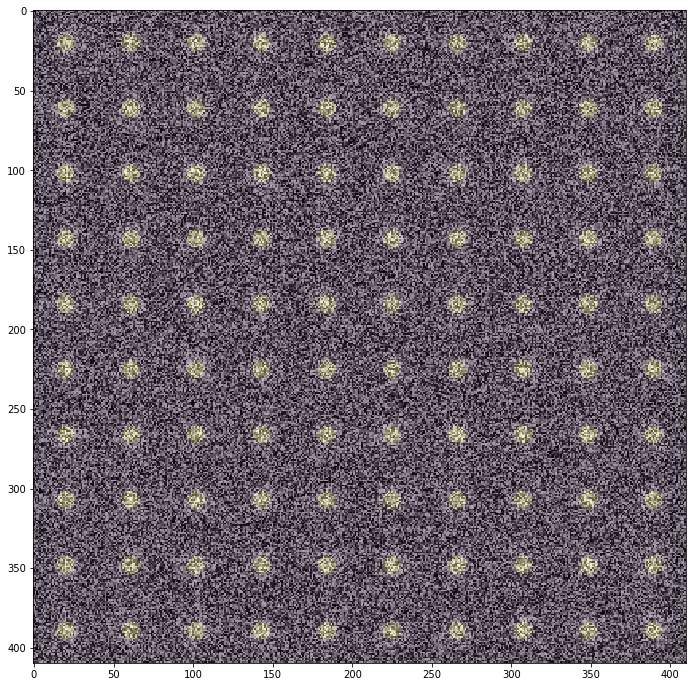

In [0]:
plt.figure(figsize=(12, 12))
plt.imshow(atomic_lattice_noisy, cmap='gray')
plt.imshow(atomic_lattice_labels, alpha=0.15)

Normalize to [0, 1]:

**Write the expression that normalizes noisy data to [0, 1] and stores it by overwiting the original variable**

In [0]:
atomic_lattice_noisy = # your code here

Wrap the previous steps into a single function

**You will need to do this step on your own. Add 4 lines of code here (lines 19-22)**

In [0]:
def lattice_generation(atom, label, noise_level, tile_n=5):
    """
    Generates images of noisy lattice with the corresponding ground truth
    from an atom-like object and the corresponding ground truth (label)
    
    Args:
        atom: 2D numpy array of an atom-like object (e.g. 2D Gaussian blob)
        label: 2D numpy array of ones representing an atomic filled atomic contour
        noise_level: controls level of Gaussian noise
        tile_n: number of repetitions along each axis (controls size of the lattice)
        
    Returns:
        2D numpy arrays of artificial atomic lattice and 
        the corresponding ground truth describing atomic contours 
    """
    
    #### Please fill in the following 4 lines ####
    
    # tile "atom"
    # tile "label"
    # add noise
    # normalize to [0, 1]
    
    # Adding pseudodimensions of 1 (our input needs to be a 4d tensor)
    w, h = atomic_lattice.shape
    atomic_lattice_noisy = atomic_lattice_noisy.reshape(1, 1, w, h)
    atomic_lattice_labels = atomic_lattice_labels.reshape(1, 1, w, h)
    
    return atomic_lattice_noisy, atomic_lattice_labels

Test how the newly defined function works:

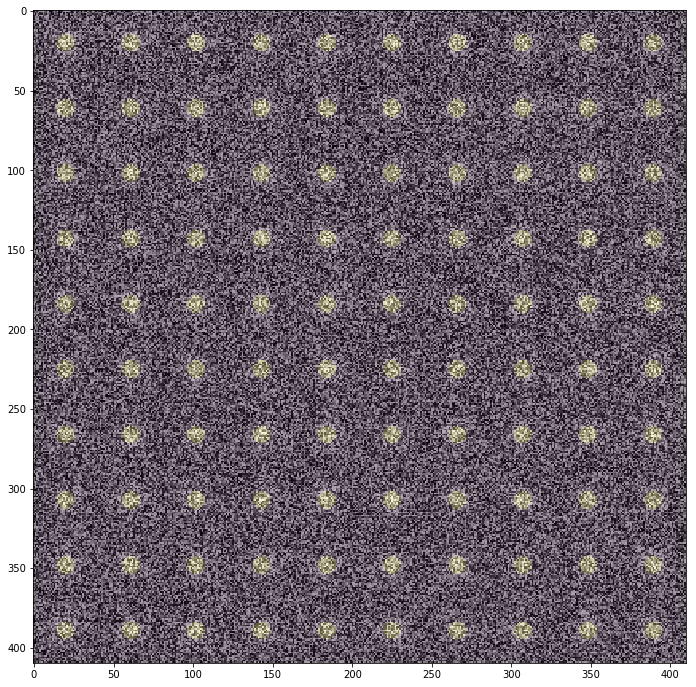

In [0]:
atomic_lattice_noisy, atomic_lattice_labels = lattice_generation(atom, label, noise_level=3)

plt.figure(figsize=(12, 12))
plt.imshow(atomic_lattice_noisy[0, 0, :, :], cmap='gray')
plt.imshow(atomic_lattice_labels[0, 0, :, :], alpha=0.15)

## NumPy <--> PyTorch

Here we will practice how to convert numpy arrays to pytorch tensor (and vice versa) and also how to move the pytorch tensors to GPU and back. In fact, one of the main advantages of using pytorch tensors is that you can transfer them to GPU device for faster computations involving tensor operations, which you cannot do for the regular numpy arrays. This significantly speeds up the training of neural networks.

Import PyTorch:

In [0]:
import torch

We can view a number of available GPU devices by running a cell below (you can turn off/on a GPU support in *Runtime --> Change runtime type*)

In [0]:
torch.cuda.device_count()

1

We can also view device specs by running a cell below:

In [0]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15079MB, multi_processor_count=40)

Here we convert a numpy array of "noisy atomic lattice" to torch tensor:

In [0]:
atomic_lattice_noisy = torch.from_numpy(atomic_lattice_noisy)

Transfer the pytorch tensor to GPU device:

In [0]:
atomic_lattice_noisy = atomic_lattice_noisy.cuda()

Confirm that the tensor is "sitting" on GPU device:

In [0]:
atomic_lattice_noisy.is_cuda

True

Now transfer it back to CPU:

In [0]:
atomic_lattice_noisy = atomic_lattice_noisy.cpu()

Confirm that it is no longer on GPU device:

In [0]:
atomic_lattice_noisy.is_cuda

False

**Small caveat:** Our numpy arrays are 64 bit floating point number by default, which is cast to DoubleTensor when `torch.from_numpy()` is called. When training our model, however, our weights will be FloatTensor (32 bit floating point) by default. This mismatch will cause an error. The easiest solution is to cast a DoubleTensor to FloatTensor by simply calling `.float()`, i.e. `atomic_lattice_noisy = torch.from_numpy(atomic_lattice_noisy).float()`.

## Build and train a neural network

Each layer of a neural network is parameterized by its weights and during the training the network is learning to match input (e.g. noisy atomic image) to target output (atoms location) by adjusting/optimizing the weights. Once trained, the network should be able to generalize to previously unseen data. This ability to generalize is perhaps the most important property of neural networks and is directly related to the details of network structure and the training procedure. Below is a schematic depiction of a neural network training concept adapted with changes from François Chollet's book "Deep Learning with Python": <br><br>

![NNtraining](https://drive.google.com/uc?export=view&id=1DaG4ll65ogK-SfzEiCMqWb0C4_pMhKqI)

Now we are ready to build our first deep learning model. We will be using torch.nn.Sequential module for this. Do not run the next cell but instead just press TAB inside the empty parenthesis of torch.nn.Sequential to view useful info about the Sequential module for a neural network construction and some usage examples.

In [0]:
torch.nn.Sequential()

Here we will construct a simple convolutional autoencoder for image denoising and atom finding. The "encoder" part consists of alternating [convolutional layers](https://en.wikipedia.org/wiki/Convolutional_neural_network#Convolutional_layer) activated by rectified linear unit [(ReLU)](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) for feature extraction and [max-pooling](https://computersciencewiki.org/index.php/Max-pooling_/_Pooling) for reducing the size of data and accounting for transaltion invariance. The decoder maps the extracted features (in this case, asssociated with "atomic contours") back to the resolution of the input image. The decoder has the same convolutional layers as the encoder but in the reversed order and the upsampling layers instead of max-pooling layers. The final layer categorizes every pixel in the image as either beloning to atom or to "background". Notice that in the image below we showed a slightly smaller network than the one than we are implementing in the cell below:
<br><br>

![DCAE](https://drive.google.com/uc?export=view&id=1osdXlLuEk-oicchzkoHDpP87GKb1tCiu)

Build a model:

In [0]:
model = torch.nn.Sequential(torch.nn.Conv2d(in_channels=1, out_channels=20, kernel_size=3, padding=1),
                            torch.nn.ReLU(),
                            torch.nn.MaxPool2d(kernel_size=2, stride=2),
                            
                            torch.nn.Conv2d(in_channels=20, out_channels=40, kernel_size=3, padding=1),
                            torch.nn.ReLU(),
                            torch.nn.MaxPool2d(kernel_size=2, stride=2),
                            
                            torch.nn.Conv2d(in_channels=40, out_channels=80, kernel_size=3, padding=1),
                            torch.nn.ReLU(),
                            torch.nn.MaxPool2d(kernel_size=2, stride=2),
                            
                            torch.nn.Conv2d(in_channels=80, out_channels=80, kernel_size=3, padding=1),
                            torch.nn.ReLU(),
                            torch.nn.Upsample(scale_factor=2, mode='bilinear'),
                            
                            torch.nn.Conv2d(in_channels=80, out_channels=40, kernel_size=3, padding=1),
                            torch.nn.ReLU(),
                            torch.nn.Upsample(scale_factor=2, mode='bilinear'),
                            
                            torch.nn.Conv2d(in_channels=40, out_channels=20, kernel_size=3, padding=1),
                            torch.nn.ReLU(),
                            torch.nn.Upsample(scale_factor=2, mode='bilinear'),
                            
                            torch.nn.Conv2d(in_channels=20, out_channels=1, kernel_size=1, padding=1),
                            torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=1, padding=0),                                                     
        )

Specify loss/function criterion (we'll use binary cross-entropy) and weights optimizer (we'll use an [Adam](https://arxiv.org/abs/1412.6980) optimizer):

In [0]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Transfer model to GPU for faster computations:

In [0]:
model = model.cuda()

Finally, we train our simple model:

(this shouldn't take longer than 3-4 minutes)

In [0]:
EPOCHS = 10000

for e in range(EPOCHS):
    # clear gradients from a previous run
    optimizer.zero_grad()
    # generate image-label pair
    noise_level = np.random.randint(100, 300) / 100 # generate a random noise level for every epoch
    X_train, y_train = lattice_generation(atom, label, noise_level)
    # Convert numpy arrays to pytorch tensors
    X_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).float()
    # Transfer the pytorch tensors to GPU
    X_train = X_train.cuda()
    y_train = y_train.cuda()
    # propagate variable X_train through a network and get model's prediction
    y_predicted = model(X_train)
    # compare predicted value with true value and calculate mean squared error
    loss = criterion(y_predicted, y_train)
    # do backpropagation to compute gradients
    loss.backward()
    # optimize weights
    optimizer.step() 
    # print statistics
    if e % 100 == 0:
        print('Epoch: {}  Loss: {}'.format(e, loss.item()))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Epoch: 0  Loss: 0.9131857752799988
Epoch: 100  Loss: 0.21925035119056702
Epoch: 200  Loss: 0.07734932750463486
Epoch: 300  Loss: 0.0548849031329155
Epoch: 400  Loss: 0.03304709494113922
Epoch: 500  Loss: 0.04048505052924156
Epoch: 600  Loss: 0.026726126670837402
Epoch: 700  Loss: 0.020871860906481743
Epoch: 800  Loss: 0.024594852700829506
Epoch: 900  Loss: 0.029788294807076454
Epoch: 1000  Loss: 0.018873434513807297
Epoch: 1100  Loss: 0.025848789140582085
Epoch: 1200  Loss: 0.017958439886569977
Epoch: 1300  Loss: 0.02140597254037857
Epoch: 1400  Loss: 0.023266153410077095
Epoch: 1500  Loss: 0.017690779641270638
Epoch: 1600  Loss: 0.01984730362892151
Epoch: 1700  Loss: 0.028332192450761795
Epoch: 1800  Loss: 0.028691135346889496
Epoch: 1900  Loss: 0.024620043113827705
Epoch: 2000  Loss: 0.026112647727131844
Epoch: 2100  Loss: 0.021049054339528084
Epoch: 2200  Loss: 0.023882221430540085
Epoch: 2300  Loss: 0.016020117327570915
Epoch: 2400  Loss: 0.016116764396429062
Epoch: 2500  Loss: 0.0

Transfer model back to CPU:

In [0]:
model = model.cpu()

Generate image of atomic lattice with the noise level exceeding that used for model training and with larger number of tiles (that is, different image resolution):

In [0]:
tile_n = 8
noise_level = 5
test_data, _ = lattice_generation(atom, label, noise_level, tile_n)

Use the trained model to make prediction on this previously unseen data.

In [0]:
# Convert numpy array to torch tensor
X_test = torch.from_numpy(test_data).float()
# Make prediction
test_prediction = model(X_test)
test_prediction = torch.sigmoid(test_prediction)
# Convert prediction from torch tensor to numpy array
test_prediction = test_prediction.data.numpy()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Plot the results:

Text(0.5, 1.0, 'Network predictions with greater than 0.9 probability')

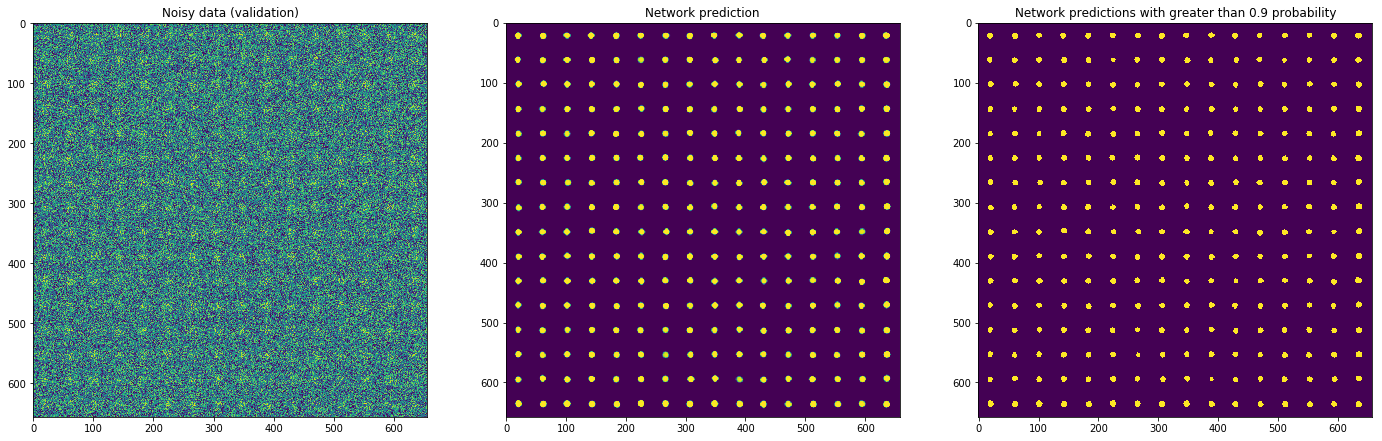

In [0]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 12)) # generate figure with 3 subplots (ax1, ax2, ax3)
ax1.imshow(X_test[0, 0, :, :]) # first subplot
ax1.set_title('Noisy data (validation)')
ax2.imshow(test_prediction[0, 0, :, :]) # second subplot
ax2.set_title('Network prediction')
ax3.imshow(test_prediction[0, 0, :, :]>0.9) # second subplot
ax3.set_title('Network predictions with greater than 0.9 probability')

The network performed pretty well given that the validation data was much noisier than the data the network "saw" during the training stage.

Let's now try some crazy amount of noise where there are no "atoms" anymore to make sure our network is not overfitting:

In [0]:
tile_n = 8
noise_level = 35
test_data, _ = lattice_generation(atom, label, noise_level, tile_n)

Use the trained model to make prediction on this previously unseen data.

In [0]:
# Convert numpy array to torch tensor
X_test = torch.from_numpy(test_data).float()
# Make prediction
test_prediction = model(X_test)
test_prediction = torch.sigmoid(test_prediction)
# Convert prediction from torch tensor to numpy array
test_prediction = test_prediction.data.numpy()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Plot the results:

Text(0.5, 1.0, 'Network predictions with greater than 0.9 probability')

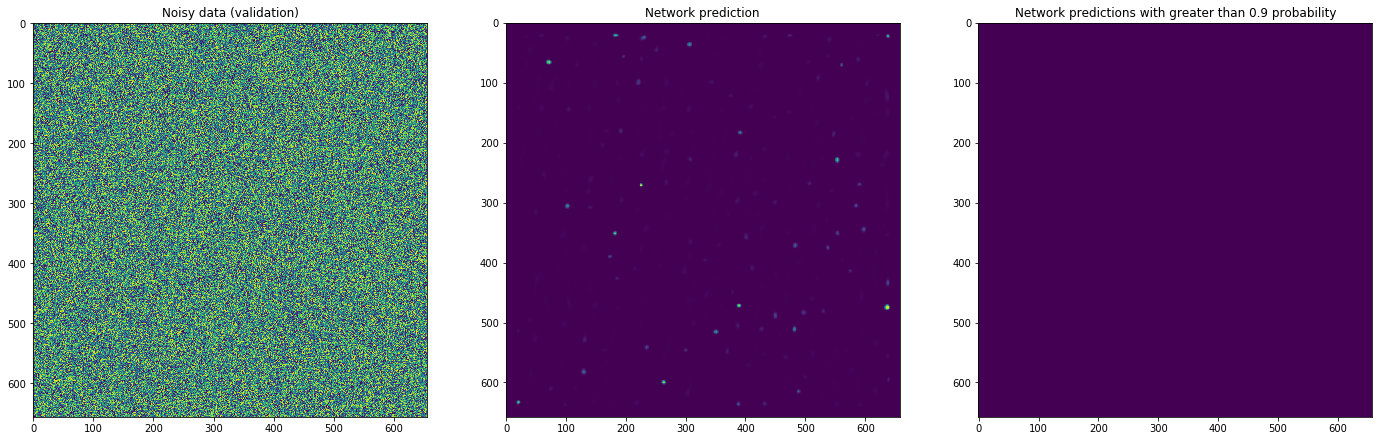

In [0]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 12)) # generate figure with 3 subplots (ax1, ax2, ax3)
ax1.imshow(X_test[0, 0, :, :]) # first subplot
ax1.set_title('Noisy data (validation)')
ax2.imshow(test_prediction[0, 0, :, :]) # second subplot
ax2.set_title('Network prediction')
ax3.imshow(test_prediction[0, 0, :, :]>0.9) # second subplot
ax3.set_title('Network predictions with greater than 0.9 probability')